In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os


In [2]:
# Path to your event files
experiment_path = "../../runs/sac/final_runs/*/events.*"
event_files = glob.glob(experiment_path, recursive=True)

all_data = []

for file in event_files:
    print(file)
    for e in tf.compat.v1.train.summary_iterator(file):
        for v in e.summary.value:
            if v.HasField('simple_value'):  # Scalars only
                all_data.append({
                    'file': os.path.basename(file),
                    "path": file,
                    'tag': v.tag,
                    'step': e.step,
                    'value': v.simple_value
                })

df = pd.DataFrame(all_data)
print(df.head())

../../runs/sac/final_runs\sac_2_1_1000000_1771711187\events.out.tfevents.1771711187.tcml-node17.1147473.0

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
../../runs/sac/final_runs\sac_2_1_4000000_1771753724\events.out.tfevents.1771753724.tcml-node7.4075407.0
                                                file  \
0  events.out.tfevents.1771711187.tcml-node17.114...   
1  events.out.tfevents.1771711187.tcml-node17.114...   
2  events.out.tfevents.1771711187.tcml-node17.114...   
3  events.out.tfevents.1771711187.tcml-node17.114...   
4  events.out.tfevents.1771711187.tcml-node17.114...   

                                                path                     tag  \
0  ../../runs/sac/final_runs\sac_2_1_1000000_1771...  charts/episodic_return   
1  ../../runs/sac/final_runs\sac_2_1_1000000_1771...  charts/episodic_length   
2  ../../runs/sac/final_runs\sac_2_1_1000000_1771...      charts/time_return   
3  ../../runs/sac/final_runs\sac_2_1_1000000_1

In [3]:
tag_to_plot = "charts/episodic_return"
df_filtered = df[df['tag'] == tag_to_plot]
df_filtered = df_filtered[["path", "step", "value"]]
df_filtered["path"] = df_filtered["path"].str.slice(28, 50)
print(df_filtered.head())

                      path  step      value
0   c_2_1_1000000_17717111    30 -10.744033
4   c_2_1_1000000_17717111    37 -10.708597
8   c_2_1_1000000_17717111    79 -11.403031
12  c_2_1_1000000_17717111   162   5.010579
16  c_2_1_1000000_17717111   206   9.454935


In [4]:
df_filtered["value_smooth"] = (
    df_filtered.groupby("path")["value"]
      .rolling(window=int(1e3), min_periods=int(1))
      .mean()
      .reset_index(level=0, drop=True)
)

In [5]:
df_filtered["group key"] = df_filtered["path"]
df_filtered_2 = df_filtered[df_filtered["step"]<=2e6]
df_downsampled = df_filtered_2.iloc[::100, :]


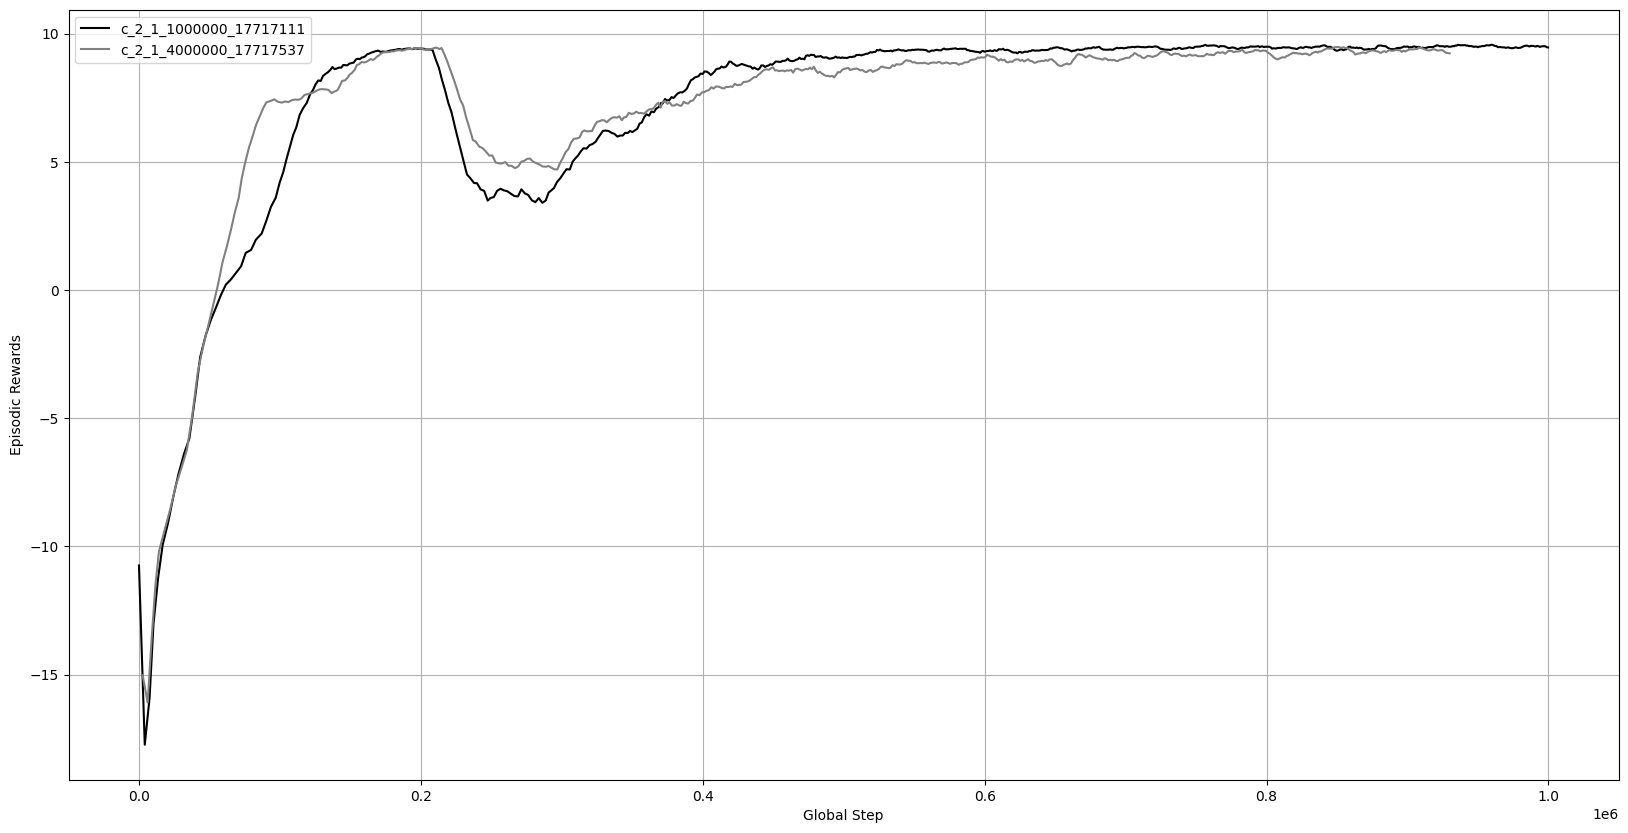

In [6]:
fig, ax = plt.subplots()
colors = ["black", "gray", "rosybrown", "lightcoral", "firebrick", "red", "peru", "darkorange", "goldenrod", "palegoldenrod", "yellow", "olive", "greenyellow", "darkseagreen", "turquoise", "teal", "indigo"]
for index, g in enumerate(df_downsampled.groupby("group key")):
    ax.plot(g[1]["step"], g[1]["value_smooth"], label=g[0], color=colors[index])
ax.grid()
fig.set_size_inches(20, 10)
plt.xlabel("Global Step")
plt.ylabel("Episodic Rewards")
plt.legend()
plt.show()

In [7]:
fig.savefig('experiments.pdf')

In [8]:
tag_to_plot = "charts/time_return"
df_filtered = df[df['tag'] == tag_to_plot]
df_filtered = df_filtered[["path", "step", "value"]]
df_filtered["path"] = df_filtered["path"].str.slice(28, 50)
print(df_filtered.head())
df_filtered["value_smooth"] = (
    df_filtered.groupby("path")["value"]
      .rolling(window=int(1e3), min_periods=int(1))
      .mean()
      .reset_index(level=0, drop=True)
)
df_filtered["group key"] = df_filtered["path"]
df_filtered_2 = df_filtered[df_filtered["step"]<=2e6]
df_downsampled = df_filtered_2.iloc[::20, :]


                      path  step      value
2   c_2_1_1000000_17717111     0 -10.744033
6   c_2_1_1000000_17717111     0 -10.708597
10  c_2_1_1000000_17717111     0 -11.403031
14  c_2_1_1000000_17717111     0   5.010579
18  c_2_1_1000000_17717111     0   9.454935


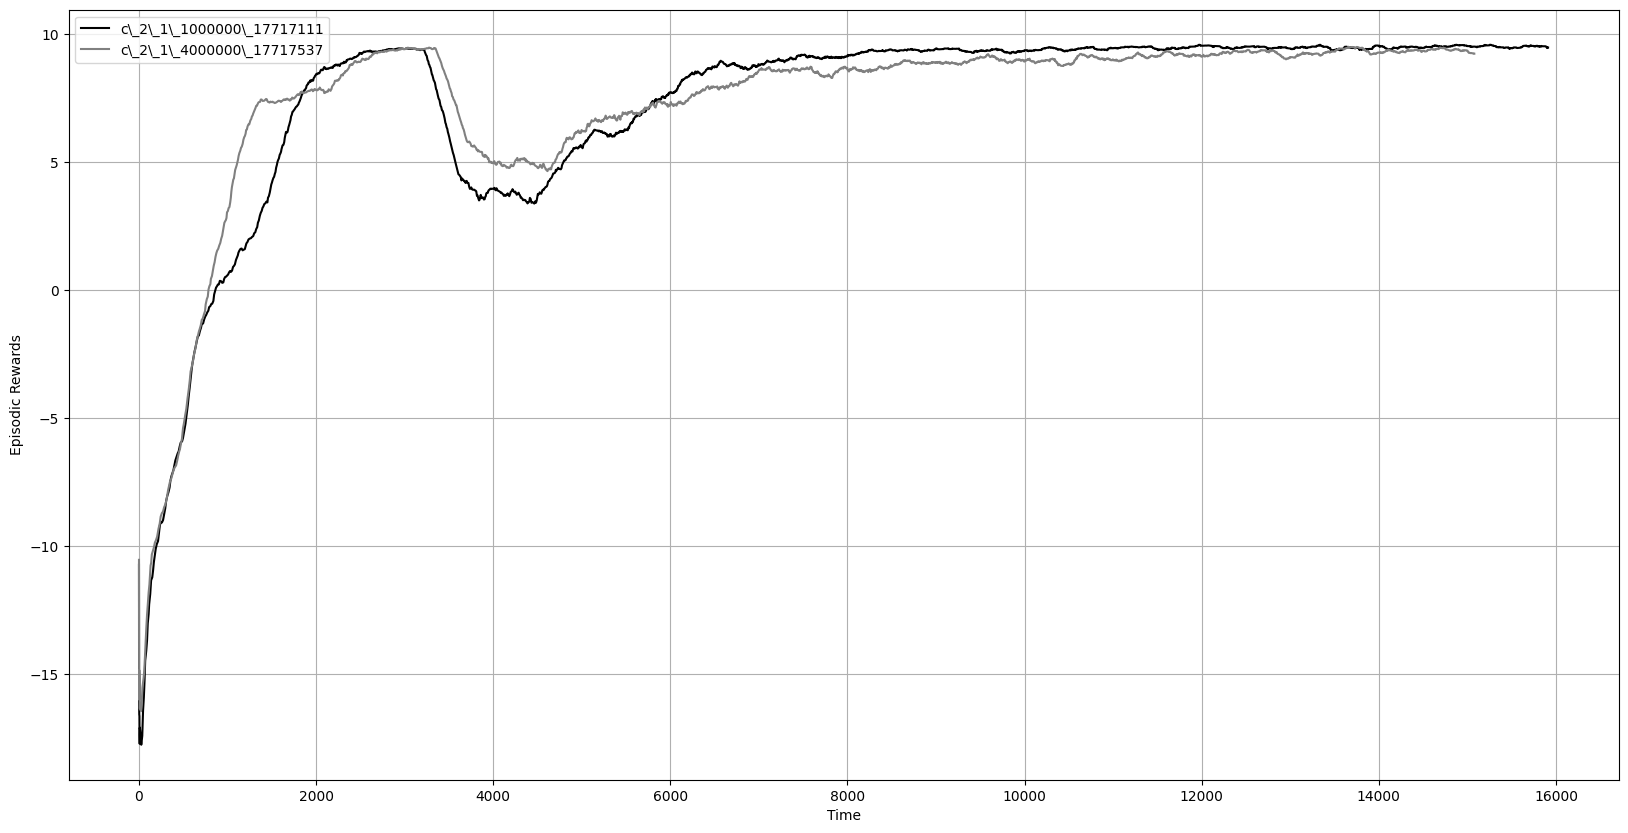

In [9]:
fig, ax = plt.subplots()
colors = ["black", "gray", "rosybrown", "lightcoral", "firebrick", "red", "peru", "darkorange", "goldenrod", "palegoldenrod", "yellow", "olive", "greenyellow", "darkseagreen", "turquoise", "teal", "indigo"]
for index, g in enumerate(df_downsampled.groupby("group key")):
    ax.plot(g[1]["step"], g[1]["value_smooth"], label=g[0].replace("_", "\\_"), color=colors[index])
ax.grid()
fig.set_size_inches(20, 10)
plt.xlabel("Time")
plt.ylabel("Episodic Rewards")
plt.legend()
plt.show()

In [10]:
fig.savefig('experiment_time.pdf')
import matplot2tikz

matplot2tikz.save("test.tikz", figure=fig)